In [1]:
import cv2
import os
import numpy as np
import cv2
from keras.models import Model, Sequential
from keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from PIL import Image
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
import matplotlib.pyplot as plt
from os import listdir
from keras.layers import Convolution2D
from keras.layers import MaxPool2D

In [29]:
cam = cv2.VideoCapture(0)
cam.set(3, 640) # set video width
cam.set(4, 480) # set video height

face_detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# For each person, enter one numeric face id
face_id = input('\n enter user id end press <return> ==>  ')

print("\n [INFO] Initializing face capture. Look the camera and move the head left right up down for 10 seconds ...")
# Initialize individual sampling face count
count = 0

while(True):

    ret, img = cam.read()
    #img = cv2.flip(img, -1) # flip video image vertically
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
    faces = face_detector.detectMultiScale(gray, 1.3, 5)

    for (x,y,w,h) in faces:

        cv2.rectangle(img, (x,y), (x+w,y+h), (255,0,0), 2)     
        count += 1

        # Save the captured image into the datasets folder
        cv2.imwrite("dataset2/User" + str(face_id) + '.' + str(count) + ".jpg", gray[y:y+h,x:x+w])

        cv2.imshow('image', img)

    k = cv2.waitKey(100) & 0xff # Press 'ESC' for exiting video
    if k == 27:
        break
    elif count >= 70: # Take 100 face sample and stop video
         break

# Do a bit of cleanup
print("\n [INFO] Exiting Program and cleanup stuff")
cam.release()
cv2.destroyAllWindows()


 enter user id end press <return> ==>  gio

 [INFO] Initializing face capture. Look the camera and move the head left right up down for 10 seconds ...

 [INFO] Exiting Program and cleanup stuff


In [14]:
# folder where images are present
TrainingImagePath='./dataset33'

from keras.preprocessing.image import ImageDataGenerator
img_rows, img_cols = 64, 64
batch_size=32

# Defining pre-processing transformations on raw images of training data
# These hyper parameters helps to generate slightly twisted versions
# of the original image, which leads to a better model, since it learns
# on the good and bad mix of images
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True)

# Defining pre-processing transformations on raw images of testing data
# No transformations are done on the testing images
test_datagen = ImageDataGenerator(rescale=1./255)

'''# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      shear_range=0.3,
      zoom_range=0.3,
      width_shift_range=0.4,
      height_shift_range=0.4,
      horizontal_flip=True,
      fill_mode='nearest')'''

# Generating the Training Data
training_set = train_datagen.flow_from_directory(
        TrainingImagePath,
        target_size=(img_rows, img_rows),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)


# Generating the Testing Data
test_set = test_datagen.flow_from_directory(
        TrainingImagePath,
        target_size=(img_rows, img_rows),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

# Printing class labels for each face DATASET OLOI
test_set.class_indices

Found 911 images belonging to 34 classes.
Found 911 images belonging to 34 classes.


{'christos': 0,
 'dora': 1,
 'face1': 2,
 'face10': 3,
 'face11': 4,
 'face12': 5,
 'face13': 6,
 'face14': 7,
 'face15': 8,
 'face16': 9,
 'face2': 10,
 'face3': 11,
 'face4': 12,
 'face5': 13,
 'face6': 14,
 'face7': 15,
 'face8': 16,
 'face9': 17,
 'gio': 18,
 'giota': 19,
 'kostas': 20,
 'maraki': 21,
 'nikos': 22,
 'nionios': 23,
 'pegk': 24,
 'peris': 25,
 'psilos': 26,
 'romanos': 27,
 'stathis2': 28,
 'stavtos': 29,
 'vill': 30,
 'xara': 31,
 'xaris': 32,
 'zisis': 33}

In [3]:
# Creating lookup table for all faces 
# class_indices have the numeric tag for each face
TrainClasses=training_set.class_indices

# Storing the face and the numeric tag for future reference
ResultMap={}
for faceValue,faceName in zip(TrainClasses.values(),TrainClasses.keys()):
    ResultMap[faceValue]=faceName


# Saving the face map for future reference
import pickle
with open("ResultsMap.pkl", 'wb') as fileWriteStream:
    pickle.dump(ResultMap, fileWriteStream)

# The model will give answer as a numeric tag
# This mapping will help to get the corresponding face name for it
print("Mapping of Face and its ID",ResultMap)

# The number of neurons for the output layer is equal to the number of faces
OutputNeurons=len(ResultMap)
print('/n The Number of output neurons: ', OutputNeurons)

Mapping of Face and its ID {0: 'christos', 1: 'dora', 2: 'face1', 3: 'face10', 4: 'face11', 5: 'face12', 6: 'face13', 7: 'face14', 8: 'face15', 9: 'face16', 10: 'face2', 11: 'face3', 12: 'face4', 13: 'face5', 14: 'face6', 15: 'face7', 16: 'face8', 17: 'face9', 18: 'gio', 19: 'giota', 20: 'kostas', 21: 'maraki', 22: 'nikos', 23: 'nionios', 24: 'pegk', 25: 'peris', 26: 'psilos', 27: 'romanos', 28: 'stathis2', 29: 'stavtos', 30: 'vill', 31: 'xara', 32: 'xaris', 33: 'zisis'}
/n The Number of output neurons:  34


In [4]:
# Create CNN deep learning model 
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import Model

# Initializing the Convolutional Neural Network
classifier= Sequential()

# STEP--1 Convolution
# Adding the first layer of CNN
# we are using the format (64,64,3) because we are using TensorFlow backend
# It means 3 matrix of size (64X64) pixels representing Red, Green and Blue components of pixels

classifier.add(Convolution2D(32, kernel_size=(5, 5), strides=(1, 1), input_shape=(64,64,3), activation='relu'))

# STEP--2 MAX Pooling
classifier.add(MaxPool2D(pool_size=(2,2)))

# ADDITIONAL LAYER of CONVOLUTION for better accuracy 
classifier.add(Convolution2D(64, kernel_size=(5, 5), strides=(1, 1), activation='relu'))

classifier.add(MaxPool2D(pool_size=(2,2)))

# STEP--3 FLattening
classifier.add(Flatten())

# STEP--4 Fully Connected Neural Network
classifier.add(Dense(64, activation='relu'))

classifier.add(Dense(OutputNeurons, activation='softmax'))
#print(classifier.summary())

In [5]:
%%time
#train model
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

'''checkpoint = ModelCheckpoint("/home/deeplearningcv/DeepLearningCV/Trained Models/face_recognition100.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]'''


# Compiling the CNN
#classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
classifier.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])


batch_size=32
nb_train_samples = 911       
nb_validation_samples = 911        

# Starting the model training
history = classifier.fit_generator(
                    training_set,
                    steps_per_epoch=nb_train_samples // batch_size,
                    epochs=12,
                    #callbacks = callbacks,
                    validation_data=test_set,
                    validation_steps=nb_validation_samples // batch_size)


#fname='clasifier_weights.h5'
#classifier.save_weights('clas-wei')
#frame='clasifier_weights.h5'
#classifier.load_weights(fname)
#classifier.save_weights("clasifier_weights2.h5")
#load_status = classifier.load_weights("clasifier_weights2.h5")
#model = Model(inputs=classifier.layers[0].input, outputs=classifier.layers[-3].output)

c:\users\skratimenos\miniconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/12
28/28 [==============================] - 12s 396ms/step - loss: 3.5484 - accuracy: 0.0360 - val_loss: 3.3891 - val_accuracy: 0.0971
Epoch 2/12
28/28 [==============================] - 10s 365ms/step - loss: 3.2381 - accuracy: 0.1269 - val_loss: 2.4312 - val_accuracy: 0.3817
Epoch 3/12
28/28 [==============================] - 12s 425ms/step - loss: 2.2782 - accuracy: 0.4097 - val_loss: 1.1083 - val_accuracy: 0.7489
Epoch 4/12
28/28 [==============================] - 12s 423ms/step - loss: 1.0041 - accuracy: 0.7892 - val_loss: 0.4037 - val_accuracy: 0.8772
Epoch 5/12
28/28 [==============================] - 11s 407ms/step - loss: 0.4587 - accuracy: 0.8749 - val_loss: 0.2034 - val_accuracy: 0.9453
Epoch 6/12
28/28 [==============================] - 10s 375ms/step - loss: 0.2401 - accuracy: 0.9499 - val_loss: 0.0954 - val_accuracy: 0.9810
Epoch 7/12
28/28 [==============================] - 9s 332ms/step - loss: 0.1623 - accuracy: 0.9649 - val_loss: 0.0302 - val_accuracy: 0.9967


Text(0.5, 0, 'Epochs')

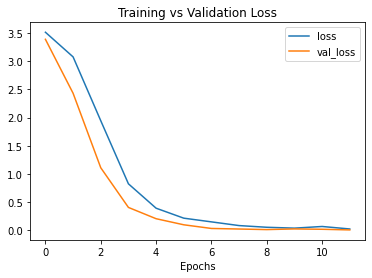

In [6]:
#model = Model(inputs=classifier.layers[0].input, outputs=classifier.layers[-3].output)
# plot training and validation loss
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot(title='Training vs Validation Loss')
plt.xlabel('Epochs')

In [63]:
class_labels = test_set.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())
#class_labels

In [15]:
cam = cv2.VideoCapture(0)
cam.set(3, 640) # set video width
cam.set(4, 480) # set video height

face_detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# For each person, enter name
face_name = input('\n enter name end press <return> ==>  ')

#print("\n [INFO] Initializing face capture. Look the camera and move the head left right up down for 10 seconds ...")
# Initialize individual sampling face count
count = 0

while(True):

    ret, img = cam.read()
    #img = cv2.flip(img, -1) # flip video image vertically
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
    faces = face_detector.detectMultiScale(gray, 1.3, 5)

    for (x,y,w,h) in faces:

        cv2.rectangle(img, (x,y), (x+w,y+h), (255,0,0), 2)     
        count += 1

        # Save the captured image into the datasets folder
        cv2.imwrite("group_of_faces/" + str(face_name) + ".jpg", gray[y:y+h,x:x+w])
        
        
        cv2.imshow('image', img)

    k = cv2.waitKey(100) & 0xff # Press 'ESC' for exiting video
    if k == 27:
        break
    elif count >= 1: # Take 1 face sample and stop video
         break

# Do a bit of cleanup
#print("\n [INFO] Exiting Program and cleanup stuff")
cam.release()
cv2.destroyAllWindows()


 enter name end press <return> ==>  stathis

 [INFO] Initializing face capture. Look the camera and move the head left right up down for 10 seconds ...


In [16]:
def preprocess_image(image_path):
    """Loads image from path and resizes it"""
    img = load_img(image_path, target_size=(64, 64))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [17]:
#points to your extracted faces
people_pictures = "./group_of_faces/"

all_people_faces = dict()

for file in listdir(people_pictures):
    person_face, extension = file.split(".")
    all_people_faces[person_face] = classifier.predict(preprocess_image('./group_of_faces/%s.jpg' % (person_face)))[0,:]

print("Face representations retrieved successfully")

def findCosineSimilarity(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

#Open Webcam
cap = cv2.VideoCapture(0) 

while(True):
    ret, img = cap.read()
    faces = face_detector.detectMultiScale(img, 1.3, 5)

    for (x,y,w,h) in faces:
        if w > 100: #Adjust accordingly if your webcam resoluation is higher
            cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2) #draw rectangle to main image
            detected_face = img[int(y):int(y+h), int(x):int(x+w)] #crop detected face
            detected_face = cv2.resize(detected_face, (64, 64)) #resize to 224x224

            img_pixels = image.img_to_array(detected_face)
            img_pixels = np.expand_dims(img_pixels, axis = 0)
            img_pixels /= 255

            captured_representation = classifier.predict(img_pixels)[0,:]

            found = 0
            for i in all_people_faces:
                person_name = i
                representation = all_people_faces[i]

                similarity = findCosineSimilarity(representation, captured_representation)
                if(similarity < 0.3):
                    cv2.putText(img, person_name[0:], (int(x+w+15), int(y-12)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                    found = 1
                    break

            #connect face and text
            cv2.line(img,(int((x+x+w)/2),y+15),(x+w,y-20),(255, 0, 0),1)
            cv2.line(img,(x+w,y-20),(x+w+10,y-20),(255, 0, 0),1)

            if(found == 0): #if found image is not in our people database
                cv2.putText(img, 'unknown', (int(x+w+15), int(y-12)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    cv2.imshow('img',img)

    if cv2.waitKey(1) == 13: #13 is the Enter Key
        break
        
cap.release()
cv2.destroyAllWindows()


import os
import glob

files = glob.glob('./group_of_faces/*')
for f in files:
    os.remove(f)

Face representations retrieved successfully


In [68]:
def loadFaceModel():
    classifier= Sequential()

    classifier.add(Convolution2D(32, kernel_size=(5, 5), strides=(1, 1), input_shape=(64,64,3), activation='relu'))

    classifier.add(MaxPool2D(pool_size=(2,2)))

    classifier.add(Convolution2D(64, kernel_size=(5, 5), strides=(1, 1), activation='relu'))

    classifier.add(MaxPool2D(pool_size=(2,2)))

    classifier.add(Flatten())

    classifier.add(Dense(64, activation='relu'))

    classifier.add(Dense(OutputNeurons, activation='softmax'))
    
    from keras.models import model_from_json    
    classifier.load_weights('clasifier_weights2.h5')
    face_descriptor = Model(inputs=classifier.layers[0].input, outputs=classifier.layers[-3].output)
    
    return face_descriptor

model = loadFaceModel()
print("Model Loaded")

Model Loaded


In [99]:
epsilon = 0.40

def verifyFace(img1, img2):
    img1_representation = classifier.predict(preprocess_image('%s' % (img1)))[0,:]
    img2_representation = classifier.predict(preprocess_image('%s' % (img2)))[0,:]
    
    cosine_similarity = findCosineSimilarity(img1_representation, img2_representation)
    
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(image.load_img('%s' % (img1)))
    plt.xticks([]); plt.yticks([])
    f.add_subplot(1,2, 2)
    plt.imshow(image.load_img('%s' % (img2)))
    plt.xticks([]); plt.yticks([])
    plt.show(block=True)
    
    print("Cosine similarity: ",cosine_similarity)
    
    if(cosine_similarity < epsilon):
        print("They are same person")
    else:
        print("They are not same person!")

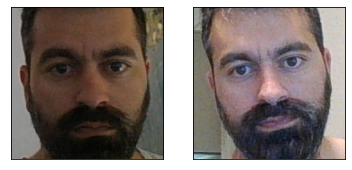

Cosine similarity:  1.0
They are not same person!


In [100]:
# Let's compare two faces images of Angelina Jolie
verifyFace("stathis.jpg", "stathis2.jpg")

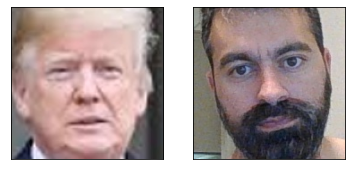

Cosine similarity:  1.0
They are not same person!


In [101]:
verifyFace("face_trump.jpg", "stathis2.jpg")

In [231]:
from pathlib import Path

extension = 'png'
path = r'C:\Users\skratimenos\Desktop\Data Science\Deep Learning\project CNN\01000'
for pic in Path(path).glob('*.' + extension):
    new_directory = pic.parent.joinpath(Path(pic.name).stem)
    Path.mkdir(new_directory, exist_ok=True)
    pic.rename(new_directory.joinpath(pic.name))